In [12]:
# Import Packages 

import numpy as np
import scipy.interpolate
import scipy.optimize as opt
import copy as copy
import matplotlib.pyplot as plt
from scipy.interpolate import PchipInterpolator as pchip
from scipy.interpolate import CubicSpline

In [2]:
# Define Parameters

beta = 0.8
R = 1.02
alpha = 1/3

In [29]:
# Define Primitive Functions 

def u(c):
    return np.log(c)

def u_dash(c):
    return 1/c

def f(k):
    return k ** alpha

def f_dash(k):
    return alpha * k ** (alpha - 1)


In [32]:
# Calculate optimal k 

def calculate_optimal_k(R, alpha): 
    return (R / alpha) ** (1 / (alpha - 1))

k_star = calculate_optimal_k(R, alpha)

In [34]:
# Functions to solve FOCs 

def threshold_FOC(w, phi, v_dash):
    target = u_dash(w - (1-phi) * k_star) - beta * R * v_dash(f(k_star) - R * phi * k_star) 
    return target 

def bonds_foc(b, w, phi, v_dash): ## FOC for unconstrained agent
    target = u_dash(w - b - k_star) - beta * R * v_dash(f(k_star) + R*b) 
    return target

def capital_foc(k, w, phi, v_dash):
    target = u_dash(w - (1 - phi) * k) * (1 - phi) - beta * v_dash(f(k) - R * phi * k) * (f_dash(k) - R * phi)
    return target

def solve_for_bonds(w, phi, v_dash, initial_guess):
    b = opt.fsolve(bonds_foc, initial_guess, args = (w, phi, v_dash))
    return b

def solve_for_capital(w, phi, v_dash, initial_guess): 
    k = opt.fsolve(capital_foc, initial_guess, args = (w, phi, v_dash))
    return k


In [35]:
# Set up grid

w_grid = np.linspace(0.1, 5, 100)

# Define initial guess for threshold value of w 

w_threshold = 0.2


In [38]:
# Process of value function iteration 

def vfi(phi): 

    k_star = calculate_optimal_k(R, alpha)

    # Initialize policy functions 

    b_policy = np.zeros(len(w_grid))
    k_policy = np.ones(len(w_grid)) * k_star
    # Initialize value function

    # v = np.log(w_grid)

    v = np.zeros(len(w_grid))

    # Form a loop to iterate until we are below a specified tolerance

    tol = 1e-6

    error = 1

    iter = 0

    while error > tol: # and iter < 10:

        iter = iter + 1

        # Create a smooth differentiable approximation to the value function

        v_approx = CubicSpline(w_grid, v)

        # plot v_approx and v against w_grid 

        # plt.plot(w_grid, v_approx(w_grid), label = 'v_approx')
        # # plt.plot(w_grid, v, label = 'v')
        # plt.legend()
        # plt.show()

        # Calculate derivative of v_approx

        v_approx_dash = v_approx.derivative(1)

        # Plot derivative of v_approx

        # plt.plot(w_grid, v_approx_dash(w_grid))
        # plt.show()

        # Given v_approx_dash, calculate threshold value of w: 

        w_threshold = opt.fsolve(threshold_FOC, 1, args = (phi, v_approx_dash))

        k_guess = k_star 
        b_guess = 0

        v_new = np.zeros(len(w_grid))

        for i in range(len(w_grid)):

            # Calculate policy functions for w < w_threshold, which corresponds to the constrained agent

            if w_grid[i] < w_threshold: 

                k_policy[i] = solve_for_capital(w_grid[i], phi, v_approx_dash, k_guess)
                b_policy[i] = - phi * k_policy[i]

            else: 

                # Calculate policy functions for w >= w_threshold, which corresponds to the unconstrained agent

                b_policy[i] = solve_for_bonds(w_grid[i], phi, v_approx_dash, b_guess)
                k_policy[i] = k_star

            v_new[i] = u(w_grid[i] - b_policy[i] - k_policy[i]) + beta * v_approx(f(k_policy[i]) + R * b_policy[i])

            # Update guess for k and b

            k_guess = k_policy[i]
            b_guess = b_policy[i]

        error = np.max(np.abs(v_new - v))

        print(error)

        v = copy.deepcopy(v_new)

        ## plot v_new agaist w_grid

        # plt.plot(w_grid, v_new)
        # plt.show()

        # print(v)
        # print("Capital Policy")
        # print(k_policy)
        # print("Bonds Policy")
        # print(b_policy)

    return v, b_policy, k_policy, w_threshold
        

In [39]:
v, b_policy, k_policy, w_thrshold = vfi(0.8)

C:\Users\tomru\AppData\Local\Temp\ipykernel_9048\4161084352.py:10: RuntimeWarning: invalid value encountered in power
  return k**alpha
C:\Users\tomru\AppData\Local\Temp\ipykernel_9048\4161084352.py:13: RuntimeWarning: invalid value encountered in power
  return alpha*k**(alpha-1)


2.7704075215858475
0.7701652668966295
0.6161518692080792
0.4929232219371884
0.39433756703040634
0.31547092222252626
0.25237657684980086
0.20190132357379004
0.16150697311165135
0.12911445222546436
0.10329009848701143
0.08263202302338479
0.0661056162207061
0.05288449288982733
0.04230759430843789
0.033846075446615775
0.027076860357288624
0.021661488285831254
0.017329190628665447
0.01386335250293369
0.011090682002346863
0.008872545601877668
0.007098036481502312
0.005678429185202116
0.0045427433481619595
0.0036341946785301005
0.0029073557428249686
0.002325884594259975
0.0018607076754086904
0.0014885661403272188
0.0011908529122623968
0.0009526823298102727
0.0007621458638484846
0.0006097166910787877
0.0004877733528632078
0.00039021868229127676
0.0003121749458330214
0.00024973995666699444
0.0001997919653338176
0.0001598335722676758
0.00012786685781418505
0.00010229348625134804
8.183478900214425e-05
6.546783120198185e-05
5.2374264961407846e-05
4.189941197019209e-05
3.3519529576864215e-05
2.6815

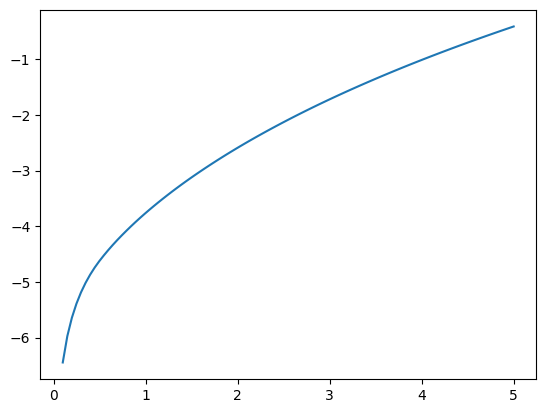

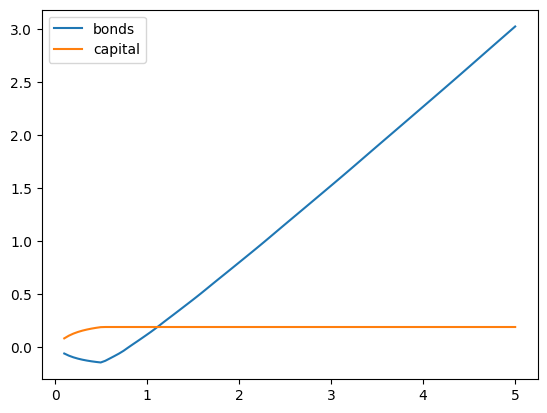

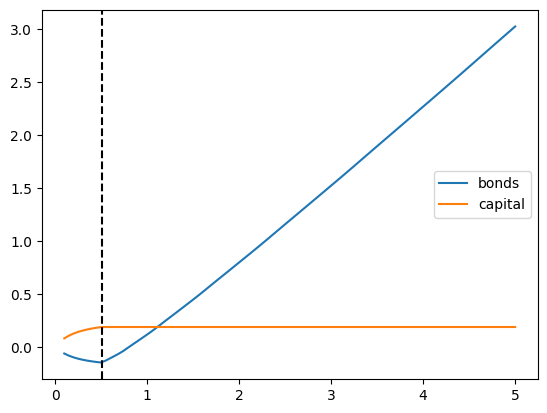

In [42]:
# Plot value function 

plt.plot(w_grid, v)
plt.show()

# Plot policy functions

plt.plot(w_grid, b_policy, label = 'bonds')
plt.plot(w_grid, k_policy, label = 'capital')
plt.legend()
plt.show()

# Plot policy functions and a dotted vertical line at w_threshold

plt.plot(w_grid, b_policy, label = 'bonds')
plt.plot(w_grid, k_policy, label = 'capital')
plt.axvline(x = w_thrshold, color = 'k', linestyle = '--')
plt.legend()
plt.show()

